In [ ]:
# ! pip install keras_sequential_ascii
# !pip install scikit-plot
# from google.colab import drive                    # drive
# drive.mount("/content/drive")                                                     # drive
# import os
# os.chdir("/content/drive/My Drive/assignments/north_umbrea/archive")              # drive, set path

In [1]:
import os
import numpy as np
import tensorflow as tf 
import tensorflow_hub as hub 
from sklearn.utils import shuffle 
from matplotlib import pyplot as plt 
from tensorflow.keras import Sequential 
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, RandomFlip, RandomRotation, RandomZoom, Dropout, Resizing

In [2]:
path = os.getcwd()                                                                  # local
path = path+'\\'+"archive"                                                          # local
os.chdir(path)                                                                      # local 

In [3]:
X = np.load("X.npy")
Y = np.load("Y.npy")
print('shape of X : ',X.shape,'\n') 
print('Input image shape : ',X[0].shape,'\n')
print('Total number of samples : ',Y.shape,'\n')
print('class distribution \n: ',np.array(np.unique(Y, return_counts=True)).T)

shape of X :  (5547, 50, 50, 3) 

Input image shape :  (50, 50, 3) 

Total number of samples :  (5547,) 

class distribution 
:  [[   0 2759]
 [   1 2788]]


*   The dataset consists of two '.npy' formated files with 5547 sample images of specimens with or without breast cancer. This data set is obtained from [kaggle](https://www.kaggle.com/datasets/simjeg/lymphoma-subtype-classification-fl-vs-cll?datasetId=1260&sortBy=voteCount). 
*   Kaggle obtained this data set from Andrew Janowczyk who explained the detailed image processing methods [here](http://www.andrewjanowczyk.com/use-case-6-invasive-ductal-carcinoma-idc-segmentation/) to obtain 50*50*3 shaped images from the original [larger data set](http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip) 
*   The X.npy file is of shape (5547, 50, 50, 3) which is a collection of RGB images with 50*50 resolution and 5547 samples

*   The 'Y.npy' file consists of image lables as ones and zeros indicating if a corresponding image in X is cancerous or not 

*   label value = 0 : no invasive ductal carcinoma, label value = 1 :  invasive ductal carcinoma

**A look at some of the images along with their labels on X-axis**

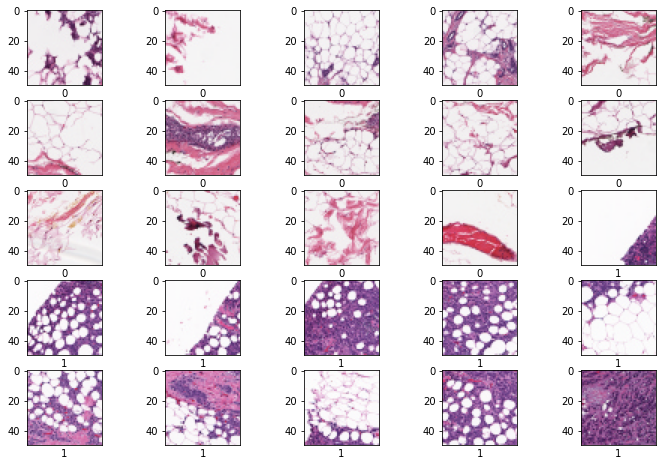

In [4]:
plt.figure(figsize=(12,8))
for imageNum in range(25):
    plt.subplot(5,5,imageNum+1)
    plt.xticks([])  # Disable xticks
    plt.imshow(X[2745+imageNum]) 
    plt.xlabel(Y[2745+imageNum])
plt.show()

looking at the above figures we see that cancerous samples are distinctly coloured from the non-cancerous onoes.  

## **Preprocessing**
*    Images generally have rgb values in range 0 to 255 as so in this case. We rescale these values between 0 and 1. Neural networks are trained on smaller values of initial weights and for faster training larger values to the input variables are not preferred. we normalize the pixel values. 
*    we can increase the number of samples in the images by transformations like random flipping, random zooming and random rotations as these transformations do not effect the classification labels. Moreover training with such augumented data makes our model more robust as real images are generally taken without predefined such parameters. Thus over model picks up better patterns while learnng as it is exposed to the fact that images are invariant under such transformations. 

In [5]:
print('Max value of a pixel value: ',X.max())

Max value of a pixel value:  255


we need to divide the pixel values by 255 for rescaling the pixel values. Also in the data set all the sample images above the 2760 numpy arry index are positively labeled and below it are negatively labeled. For a good train test split we first shuffle the image and label arrays together

In [6]:
x, y = shuffle(X, Y, random_state=11)

Next we split the dataset in to training and testing components where 70% data goes for training and rest for testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3, shuffle=True)
X_train = tf.convert_to_tensor(X_train, np.float32)                   # numpy to tensor
y_train = tf.convert_to_tensor(y_train, np.float32) 
X_test = tf.convert_to_tensor(X_test, np.float32)
y_test = tf.convert_to_tensor(y_test, np.float32)
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 2)       # one-hot representation
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 2) 
distribution = np.array(np.unique(y_train, return_counts=True)).T
print('number of non cancerous images in training data: ',distribution[0][1])
print('number of cancerous images in training data: ',distribution[1][1])

number of non cancerous images in training data:  3882.0
number of cancerous images in training data:  3882.0


*    The classes are nearly balanced. 
*    Lets define a deep neural network model with a series of convolutional layers. 
*    Inorder to minimize the information loss from an image during convolutions we use zero padding to retain the image size.
*    first two layers are preprocessing layers
*    next 4 layers are pairs of convolutional layers followed by maxpooling
*    kernal size = (3,3)
*    Then the layers are flattened and passed to another hidden layer of 512 units with 40% dropout rate to reduce overfitting.
*    Finally a dense layer for classification output at the bottom of the pipeline

In [8]:
IMG_SIZE = 50    
resize_and_rescale = Sequential([ Resizing(IMG_SIZE, IMG_SIZE), Rescaling(1.0/255) ]) 
data_augmentation = Sequential([ RandomFlip("horizontal_and_vertical"), RandomRotation(0.2), RandomZoom(0.1)]) 
model = Sequential([
  resize_and_rescale,
  data_augmentation,
  Conv2D(32, (3,3), activation='relu', padding='same'), MaxPooling2D(2, 2),
  Conv2D(64, (3,3), activation='relu', padding='same'), MaxPooling2D(2,2),
  Conv2D(128, (3,3), activation='relu', padding='same'), MaxPooling2D(2,2),
  Conv2D(128, (3,3), activation='relu', padding='same'), MaxPooling2D(2,2),
  Flatten(),
  Dropout(0.4),                    
  Dense(512, activation='relu'),
  Dense(2, activation='softmax')
]) 

In [10]:
model.compile( loss=tf.keras.losses.CategoricalCrossentropy () , metrics=['accuracy']) 
model.build([None, IMG_SIZE, IMG_SIZE, 3])  
model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 50, 50, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                  

In [11]:
from keras_sequential_ascii import keras2ascii 
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     50   50    3
          Sequential   ????? -------------------         0     0.0%
                       #####     50   50    3
          Sequential   ????? -------------------         0     0.0%
                       #####     50   50    3
              Conv2D    \|/  -------------------       896     0.1%
                relu   #####     50   50   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     25   25   32
              Conv2D    \|/  -------------------     18496     2.2%
                relu   #####     25   25   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   64
              Conv2D    \|/  -------------------     73856     8.9%
                relu   #####     12   12  128
        MaxPooling2D   Y max -------------------         0     0.0%
              

In [12]:
num_epoches = 100
result = model.fit(X_train, y_train, epochs = num_epoches, validation_split = 0.15)

Epoch 1/100
104/104 [==============================] - 13s 114ms/step - loss: 0.7266 - accuracy: 0.5790 - val_loss: 0.6464 - val_accuracy: 0.6346
Epoch 2/100
104/104 [==============================] - 13s 127ms/step - loss: 0.6335 - accuracy: 0.6766 - val_loss: 0.9411 - val_accuracy: 0.5129
Epoch 3/100
104/104 [==============================] - 11s 110ms/step - loss: 0.6129 - accuracy: 0.6893 - val_loss: 0.8879 - val_accuracy: 0.5249
Epoch 4/100
104/104 [==============================] - 12s 113ms/step - loss: 0.5859 - accuracy: 0.7090 - val_loss: 0.9480 - val_accuracy: 0.5798
Epoch 5/100
104/104 [==============================] - 11s 106ms/step - loss: 0.5804 - accuracy: 0.7060 - val_loss: 0.5599 - val_accuracy: 0.6998
Epoch 6/100
104/104 [==============================] - 11s 109ms/step - loss: 0.5714 - accuracy: 0.7169 - val_loss: 0.6169 - val_accuracy: 0.6587
Epoch 7/100
104/104 [==============================] - 12s 111ms/step - loss: 0.5566 - accuracy: 0.7266 - val_loss: 0.8642 -

#### Model evaluation

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Average training accuracy = ',np.mean(result.history['accuracy'])) 
print('Average validation accuracy = ',np.mean(result.history['val_accuracy']))
print('Average testing accuracy = ', test_accuracy)  

53/53 [==============================] - 2s 29ms/step - loss: 0.4957 - accuracy: 0.7748
Average training accuracy =  0.7717368882894516
Average validation accuracy =  0.6951629507541657
Average testing accuracy =  0.7747747898101807


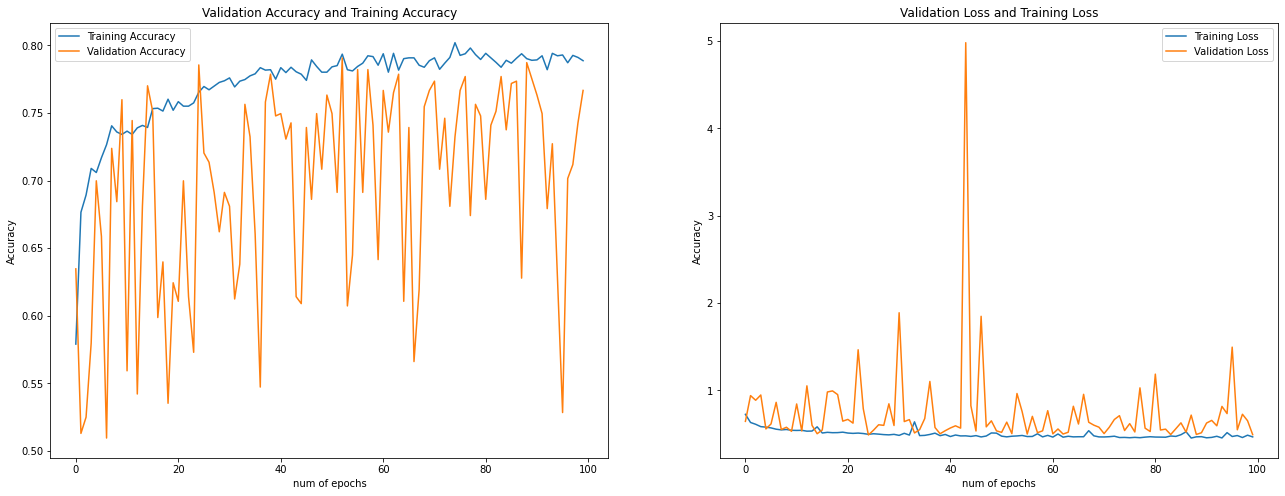

In [14]:
Accuracy, loss, ValidationAcccuracy, validationLoss = result.history['accuracy'], result.history['loss'], result.history['val_accuracy'], result.history['val_loss']

plt.figure(figsize=(22, 8))
plt.subplot(1, 2, 1)
plt.title('Validation Accuracy and Training Accuracy')
plt.plot(range(num_epoches), Accuracy, label='Training Accuracy')
plt.plot(range(num_epoches), ValidationAcccuracy, label='Validation Accuracy')
plt.xlabel('num of epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Validation Loss and Training Loss')
plt.plot(range(num_epoches), loss, label='Training Loss')
plt.plot(range(num_epoches), validationLoss, label='Validation Loss')
plt.xlabel('num of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
y_pred = model.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1) 
print(classification_report(y_test_int,y_pred_int))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75       811
           1       0.74      0.86      0.80       854

    accuracy                           0.77      1665
   macro avg       0.78      0.77      0.77      1665
weighted avg       0.78      0.77      0.77      1665



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

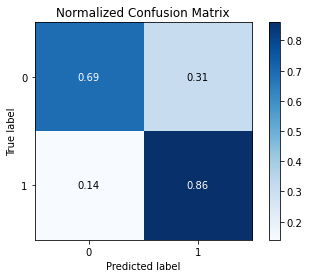

In [16]:
plot_confusion_matrix(y_test_int, y_pred_int, normalize=True)

Text(0.5, 1.0, 'ROC curve')

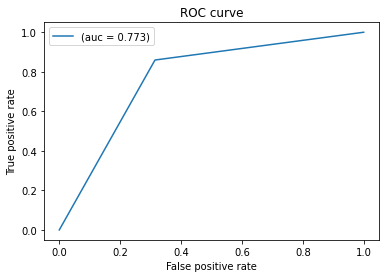

In [17]:
fp, tp, thr = roc_curve(y_test_int, y_pred_int)
auc_val = auc(fp, tp)
plt.plot(fp, tp, label='(auc = {:.3f})'.format(auc_val))
plt.ylabel('True positive rate') 
plt.xlabel('False positive rate') 
plt.legend() 
plt.title('ROC curve') 

In [18]:
model.save('model1.h5')

## Using pre-trained mobilenet model

*    Mobile net expects the image size to be in 224/224/3 shape where as the images in the data set are 50/50/3 shaped. To account for this we add image resizing layer in the pipeline along with the rescaling layer.
*    Also we set the offset value after normalization in accordance with the requirements of mobilenet.

In [19]:
IMG_SIZE = 224                                                                                  
resize_and_rescale = Sequential([ Resizing(IMG_SIZE, IMG_SIZE), Rescaling(1.0/255, offset=-1) ]) 
data_augmentation = Sequential([ RandomFlip("horizontal_and_vertical"), RandomRotation(0.2), RandomZoom(0.1)]) 
# Top layer of the pretrained model is removed
base = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE) + (3,), include_top=False, weights='imagenet')  #pretrained on 1.4M images and 1000 classes
base.trainable = False 
print(base.summary()) 
print("Number of layers in the MobileNet model: ", len(base.layers)) 
Transfermodel = Sequential([ resize_and_rescale,  data_augmentation, base, Flatten(), Dense(2, activation='softmax')])   

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [20]:
Transfermodel.build([None, 224, 224, 3])  
print('Num of trainable parameters',len(Transfermodel.trainable_variables))
Transfermodel.compile( loss=tf.keras.losses.CategoricalCrossentropy () , metrics=['accuracy']) 
print(Transfermodel.summary() )
num_epoches = 50
result2 = Transfermodel.fit(X_train, y_train, epochs = num_epoches, validation_split = 0.15) 

Num of trainable parameters 2
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 125442    
                                                                 
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
________

In [21]:
test_loss, test_accuracy = Transfermodel.evaluate(X_test, y_test) 
print('Average training accuracy = ',np.mean(result.history['accuracy']))
print('Average validation accuracy = ',np.mean(result.history['val_accuracy']))
print('Average testing accuracy = ', test_accuracy)  

53/53 [==============================] - 40s 747ms/step - loss: 5.5561 - accuracy: 0.7423
Average training accuracy =  0.7717368882894516
Average validation accuracy =  0.6951629507541657
Average testing accuracy =  0.7423423528671265


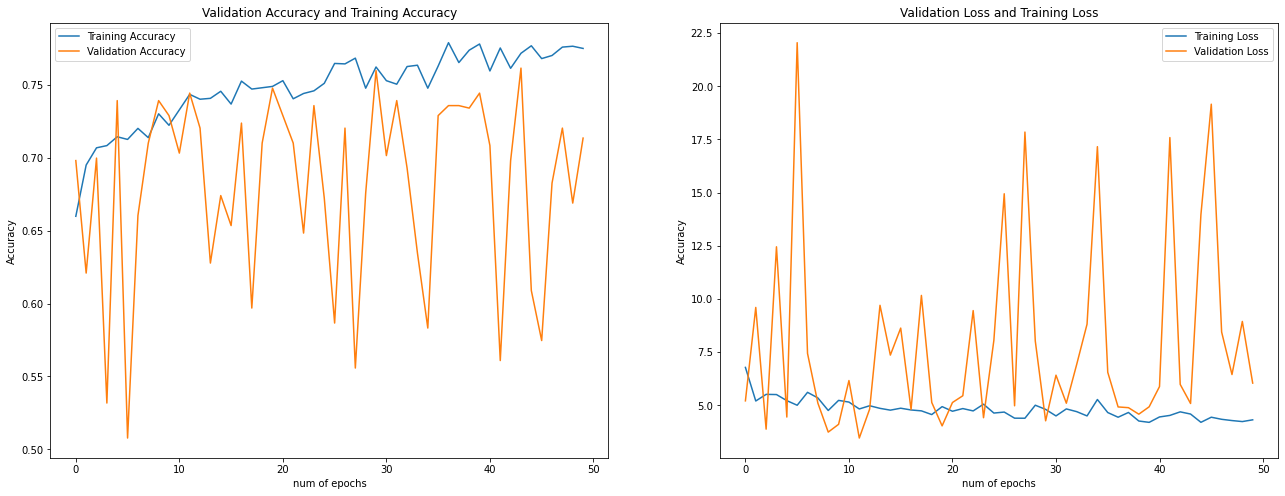

In [22]:
Accuracy, loss, ValidationAcccuracy, validationLoss = result2.history['accuracy'], result2.history['loss'], result2.history['val_accuracy'], result2.history['val_loss']

plt.figure(figsize=(22, 8))
plt.subplot(1, 2, 1)
plt.title('Validation Accuracy and Training Accuracy')
plt.plot(range(num_epoches), Accuracy, label='Training Accuracy')
plt.plot(range(num_epoches), ValidationAcccuracy, label='Validation Accuracy')
plt.xlabel('num of epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Validation Loss and Training Loss')
plt.plot(range(num_epoches), loss, label='Training Loss')
plt.plot(range(num_epoches), validationLoss, label='Validation Loss')
plt.xlabel('num of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
y_pred = Transfermodel.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1) 
print(classification_report(y_test_int,y_pred_int))
plot_confusion_matrix(y_test_int, y_pred_int, normalize=True)

In [ ]:
fp, tp, thr = roc_curve(y_test_int, y_pred_int)
auc_val = auc(fp, tp)
plt.plot(fp, tp, label='(auc = {:.3f})'.format(auc_val))
plt.ylabel('True positive rate') 
plt.xlabel('False positive rate') 
plt.legend() 

plt.title('ROC curve') 

### Fine tuning

In [ ]:
print("Number of layers in the MobileNet model: ",len(base.layers))
print("Freezing first 130 layers") 
base.trainable = True
for layer in base.layers[:130]:
  layer.trainable = False

Transfermodel.compile( loss=tf.keras.losses.CategoricalCrossentropy () , metrics=['accuracy'])  # try implementing smaller learning rate here
Transfermodel.summary() 

In [ ]:
tune_epoch = 10
result2 = Transfermodel.fit(X_train, y_train, epochs = num_epoches+tune_epoch,initial_epoch=num_epoches, validation_split = 0.15) 

In [ ]:
Accuracy, loss, ValidationAcccuracy, validationLoss = result2.history['accuracy'], result2.history['loss'], result2.history['val_accuracy'], result2.history['val_loss']

plt.figure(figsize=(22, 8))
plt.subplot(1, 2, 1)
plt.title('Validation Accuracy and Training Accuracy')
plt.plot(range(tune_epoch), Accuracy, label='Training Accuracy')
plt.plot(range(tune_epoch), ValidationAcccuracy, label = 'Validation Accuracy')
plt.xlabel('num of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Validation Loss and Training Loss')
plt.plot(range(tune_epoch), loss, label='Training Loss')
plt.plot(range(tune_epoch), validationLoss, label='Validation Loss')
plt.xlabel('num of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred = Transfermodel.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1) 
print(classification_report(y_test_int,y_pred_int)) 

In [ ]:
plot_confusion_matrix(y_test_int, y_pred_int, normalize=True)

In [ ]:
fp, tp, thr = roc_curve(y_test_int, y_pred_int)
auc_val = auc(fp, tp)
plt.plot(fp, tp, label='(auc = {:.3f})'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()

In [ ]:
Transfermodel.save('model2.h5')

In [ ]:
# Transfermodel = Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", output_shape=[1280], trainable=False),
#     Flatten(),
#     Dense(2,  activation='softmax')
#     ]) 